# The Annotated Transformer KR

## Attention in Transformer

Transformer 에 사용되는 

### encoder-decoder attention

mimics the encoder-decoder attention mechanisms

* queries : from the previous decoder layer
* keys    : from the output of encoder
* values  : from the output of encoder

### encoder + self-attention

* queries : from the previous output of encoder
* keys    : from the previous output of encoder
* values  : from the previous output of encoder

### attention with mask

prevent leftward information flow in decoder to preserve the auto-regressive property

* implement by masking out inside of scaled dot-product attention

## Define a simple Dataset

The small-dataset WMT 2016 multimodal task, also known as Flickr30k

### why do we need maximum sequence length?

In RNN, we don't need to consider maximum sequence length since it automatically runs by rnn-cell like below. For example, if there is a input tensor which has size of `(seqlen, batch, input_size)`, output of rnn will be `(seqlen, batch, hidden_size)`.

In [1]:
import torch
import torch.nn as nn
seqlen = 10
batch = 5
hidden_size = 7
input_size = 6
rnn_cell = nn.RNNCell(input_size, hidden_size)

inputs = torch.rand(seqlen, batch, input_size)
hidden = torch.zeros(batch, hidden_size)
output = []
for t in range(seqlen):
    hidden = rnn_cell(inputs[t], hidden)
    output.append(hidden)
output = torch.stack(output)
output.size()

torch.Size([10, 5, 7])

So we don't need to consider how long the sequence length is, as it runs through `for` loop. However, all sequences are calculated together at once in "transformer", there is no method can deliver information from previous sequence to next sequence. The information only flows form bottom to top!

The reason than model can't deliver information from previous sequence to next sequence is also can consider as there is no linear mapping and activation between sequences tensors. Think about how rnn_cell function at time $t$ below.

$h_{t+1} =tanh(w_{ih}x_{t}+b_{ih}+w_{hh}h_t+b_{hh}) \qquad \text{for}\ t\ \text{in range(max-seq-len)}$

why this is important? Because linear mapping and activation is the core idea of deep learning by using a lot of activation function to approximate turth fucntion between features(neurons). If there's no linear mapping and activation, you can't find relations between input tensors.

<img src="model_arch.png" width="30%">

## Training Details

In [2]:
# import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.set_printoptions(precision=4)

* paper : https://arxiv.org/abs/1706.03762
* reference blog: http://nlp.seas.harvard.edu/2018/04/03/attention.html
* reference code: https://github.com/jadore801120/attention-is-all-you-need-pytorch

The encoder maps input sequences to a sequence of continuous representations $x=(x_1 \cdots, x_n) \rightarrow z=(z_1, \cdots, y_n)$, given $z$ generates an output sequence $y=(y_1, \cdots, y_n)$

## 3.2.1 Scaled Dot-Product Attention

<img src="scaledot_attn.png" width="30%">

In [3]:
import numpy as np
import torch
import torch.nn as nn

class ScaledDotProductAttention(nn.Module):
    """Scaled Dot-Product Attention"""
    def __init__(self, d_k, drop_rate=0.1):
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = d_k
        self.drop_out = nn.Dropout(drop_rate)
        
    def forward(self, q, k, v, mask=None):
        """
        Inputs:
        * q: (B, T_q, d_k)
        * k: (B, T_k, d_k)
        * v: (B, T_v, d_v)  //  T_k = T_v
        -------------------------------
        Outputs:
        * output: (B, T_q, d_v)
        * attn: (B, T_q, T_k)
        """
        assert q.size(2) == k.size(2), "keys & quries must have same dimension"
        assert k.size(1) == v.size(1), "T_k = T_v"
        attn = torch.bmm(q, k.transpose(1, 2))  # (B, T_q, d_k) * (B, d_k, T_k) -> (B, T_q, T_k)
        attn = attn / np.sqrt(self.d_k)
        # why doing this? 
        # for the large values of d_k, the dot products grow large in magnitude, 
        # pushing the softmax function into regions where it has extremely small gradients
        # to counteract this effect, scaled the dot products by 1/sqrt(d_k)
        # to illustrate why the dot products get large,
        # check the function 'check_dotproduct_dist'
        if mask is not None:
            attn = attn.masked_fill(mask, -np.inf)
        
        attn = torch.softmax(attn, dim=2)  # (B, T_q, T_k) --> (B, T_q, T_k)
        # fill all nan to zero
        mask_nan = torch.isnan(attn)
        attn = attn.masked_fill(mask_nan, 0)
        
        output = torch.bmm(attn, v)  # (B, T_q, T_k) * (B, T_v, d_v) --> (B, T_q, d_v), make sure that T_k == T_v
        attn = self.drop_out(attn)
        
        return output, attn

In [4]:
# ex) translation: 
# q - previous decoder
# k, v - encoder output
# mask should be (B, T_q, T_k), will talk about it later
batch = 1
T_q = 3
T_k, T_v = (4, 4)
d_k = 10
d_v = 12
mask = torch.ByteTensor([[[0, 1, 1, 1],
                          [0, 0, 1, 1],
                          [1, 1, 1, 1]]])
# mask = torch.ByteTensor([[[0, 1, 1, 1],
#                           [0, 0, 1, 1],
#                           [0, 0, 1, 1]]])
q, k, v = torch.randn((batch, T_q, d_k)), torch.randn((batch, T_k, d_k)), torch.randn((batch, T_v, d_v))
attention = ScaledDotProductAttention(d_k)

In [5]:
attention.eval()
output, attn = attention(q, k, v, mask=mask)
# output size: (B, T_q, d_v)
# attn size: (B, T_q, T_k)
output.size(), attn.size()

(torch.Size([1, 3, 12]), torch.Size([1, 3, 4]))

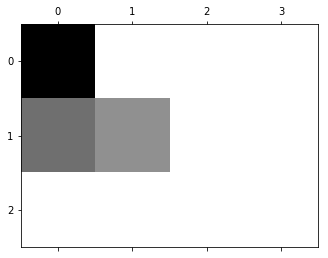

In [6]:
plt.matshow(attn.squeeze(0).numpy(), cmap="binary")
plt.show()

In [7]:
output, attn

(tensor([[[-2.2507,  0.4573,  0.4437,  0.2009, -0.0631,  0.3658,  1.2180,
            1.1180,  1.5924,  0.4960,  0.4655, -0.4090],
          [-2.0109,  0.3646,  0.5146, -0.9801, -0.2280,  0.0597,  0.4248,
            0.4102, -0.1091,  0.4236,  1.1313,  0.6272],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]]),
 tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
          [0.5640, 0.4360, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]]]))

In [8]:
def check_dotproduct_dist(d_k, sampling_size=1, seq_len=1, threshold=1e-10):
    """
    to check "https://arxiv.org/abs/1706.03762" Paper page 4, annotation 4
    -------------------------------
    To illustrate why the dot products get large, 
    assume that the components of q and k are independent random variables 
    with mean 0 and variance 1.
    Then their dot product has mean 0 and variance d_k
    
    ```
    print("*** notice that the gradient of softmax is y(1-y) ***")
    for d_k in [10, 100, 1000]:
        check_dotproduct_dist(d_k, sampling_size=100000, seq_len=5, threshold=1e-10)
    ```
    
    """
    def cal_grad(attn):
        y = torch.softmax(attn, dim=2)
        return y * (1-y)
    
    q = nn.init.normal_(torch.rand((sampling_size, seq_len, d_k)), mean=0, std=1)
    k = nn.init.normal_(torch.rand((sampling_size, seq_len, d_k)), mean=0, std=1)
    attn = torch.bmm(q, k.transpose(1, 2))
    print(f"size of vector d_k is {d_k}, sampling result, dot product distribution has")
    print(f" - mean: {attn.mean().item():.4f}, \n - var: {attn.var().item():.4f}")
    grad = cal_grad(attn)
    g_sum = grad.le(threshold).sum()
    g_percent = g_sum.item()/grad.view(-1).size(0)*100
    print(f"count of gradients that smaller than threshod({threshold}) is {g_sum}, {g_percent:.2f}%")
    
    attn2 = attn / torch.sqrt(torch.as_tensor(d_k).float())
    grad2 = cal_grad(attn2)
    g_sum2 = grad2.le(threshold).sum()
    g_percent2 = g_sum2.item()/grad2.view(-1).size(0)*100
    print(f"after divide by sqrt(d_k), count of gradients that smaller than threshod({threshold}) is {g_sum2}, {g_percent2:.2f}% \n")

In [9]:
print("*** notice that the gradient of softmax is y(1-y) ***")
for d_k in [10, 100, 1000]:
    check_dotproduct_dist(d_k, sampling_size=10000, seq_len=5, threshold=1e-10)

*** notice that the gradient of softmax is y(1-y) ***
size of vector d_k is 10, sampling result, dot product distribution has
 - mean: 0.0044, 
 - var: 10.0065
count of gradients that smaller than threshod(1e-10) is 15, 0.01%
after divide by sqrt(d_k), count of gradients that smaller than threshod(1e-10) is 0, 0.00% 

size of vector d_k is 100, sampling result, dot product distribution has
 - mean: 0.0384, 
 - var: 99.2262
count of gradients that smaller than threshod(1e-10) is 39763, 15.91%
after divide by sqrt(d_k), count of gradients that smaller than threshod(1e-10) is 0, 0.00% 

size of vector d_k is 1000, sampling result, dot product distribution has
 - mean: -0.0018, 
 - var: 999.3240
count of gradients that smaller than threshod(1e-10) is 173463, 69.39%
after divide by sqrt(d_k), count of gradients that smaller than threshod(1e-10) is 0, 0.00% 



## 3.2.2 Multi-Head Attention

<img src="multihead_attn.png" width="30%">

In [10]:
class MultiHeadAttention(nn.Module):
    """Multi-head Attention"""
    def __init__(self, n_head, d_model, d_k, d_v, drop_rate=0.1):
        """
        paper setting: n_head = 8, d_k = d_v = d_model / n_head = 64
        Multi-head attention allows the model to jointly attend to information from 
        different representation subspaces at different positions.
        with a single attention head, averaging inhibits this.
        """
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.linear_q = nn.Linear(d_model, n_head*d_k)
        self.linear_k = nn.Linear(d_model, n_head*d_k)
        self.linear_v = nn.Linear(d_model, n_head*d_v)
        nn.init.normal_(self.linear_q.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.linear_k.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.linear_v.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_v)))
        
        self.linear_o = nn.Linear(n_head*d_v, d_model)
        self.attention = ScaledDotProductAttention(d_k, drop_rate)
        self.drop_out = nn.Dropout(drop_rate)
        self.layer_norm = nn.LayerNorm(d_model)
        
    def forward(self, q, k, v, mask=None):
        """
        Inputs:
        * q: (B, T_q, d_model)
        * k: (B, T_k, d_model)
        * v: (B, T_v, d_model)
        * mask: (B, T_q, T_k)
        ---------------------
        Outputs:
        * output: (B, T_q, d_model)
        * attn: (n_head, B, T_q, T_k)
        """
        residual = q
        
        n_head, d_model, d_k, d_v = self.n_head, self.d_model, self.d_k, self.d_v
        B, T_q, _ = q.size()
        B, T_k, _ = k.size()
        B, T_v, _ = v.size()
        # through linear layer: 
        # lin_qs : (B, T_q, d_model) --> (B, T_q, n_head * d_k) --> (n_head * B, T_q, d_k)
        # lin_ks : (B, T_k, d_model) --> (B, T_k, n_head * d_k) --> (n_head * B, T_k, d_k)
        # lin_vs : (B, T_v, d_model) --> (B, T_v, n_head * d_v) --> (n_head * B, T_v, d_v)
        
        lin_qs = torch.cat(self.linear_q(q).chunk(n_head, dim=2), dim=0)
        lin_ks = torch.cat(self.linear_k(k).chunk(n_head, dim=2), dim=0)
        lin_vs = torch.cat(self.linear_v(v).chunk(n_head, dim=2), dim=0)

#         lin_qs = self.linear_q(q).view(B, T_q, n_head, d_k)
#         lin_ks = self.linear_k(k).view(B, T_k, n_head, d_k)
#         lin_vs = self.linear_v(v).view(B, T_v, n_head, d_v)

#         lin_qs = lin_qs.permute(2, 0, 1, 3).contiguous().view(-1, T_q, d_k)
#         lin_ks = lin_ks.permute(2, 0, 1, 3).contiguous().view(-1, T_k, d_k)
#         lin_vs = lin_vs.permute(2, 0, 1, 3).contiguous().view(-1, T_v, d_v)
        
        
        if mask is not None:
            mask = mask.repeat(n_head, 1, 1)

        # attention: Scaled Dot-Product Attention
        ## heads: (n_head * B, T_q, d_v)
        ## attn: (n_head * B, T_q, T_k)
        heads, attn = self.attention(q=lin_qs, k=lin_ks, v=lin_vs, mask=mask)
        # concat
        # be aware `heads.view(batch, T_q, n_head*d_k)` is not same as `torch.cat(heads.chunk(n_head, dim=0), dim=-1)`
        # (n_head * B, T_q, d_v) --> (B, T_q, n_head * d_v)
        heads_cat = torch.cat(heads.chunk(n_head, dim=0), dim=-1)
#         heads = heads.view(n_head, B, T_q, d_v)
#         heads_cat = heads.permute(1, 2, 0, 3).contiguous().view(B, T_q, -1) # b x lq x (n*dv)

        output = self.linear_o(heads_cat)  # (B, T_q, n_head * d_v) --> (B, T_q, d_model)
        output = self.drop_out(output)
        
        output = self.layer_norm(residual + output)

        return output, attn

In [11]:
batch = 1
T_q = 5
T_k, T_v = (5, 5)
n_head = 8
d_model = 3*n_head
d_k = 5
d_v = 5
mask = torch.ByteTensor([[[0, 1, 1, 1, 1],
                          [0, 0, 1, 1, 1],
                          [0, 0, 0, 0, 1],
                          [1, 1, 1, 1, 1],
                          [1, 1, 1, 1, 1]]])
q, k = torch.randn((batch, T_q, d_model)), torch.randn((batch, T_k, d_model))
v = k
q.size(), k.size(), v.size()

(torch.Size([1, 5, 24]), torch.Size([1, 5, 24]), torch.Size([1, 5, 24]))

In [12]:
multihead_attention = MultiHeadAttention(n_head, d_model, d_k, d_v)
multihead_attention.eval()
o, attn = multihead_attention(q, k, v, mask=mask)
o.size(), attn.size()

(torch.Size([1, 5, 24]), torch.Size([8, 5, 5]))

In [13]:
def draw_attentions(n_head, attn):
    """
    to see `n_head` views of attentions
    """
    fig, axes = plt.subplots(2, 4, dpi=100)
    for k in range(n_head):
        i = k % 2
        j = k // 2
        axes[i, j].matshow(attn[k].squeeze().detach().numpy(), cmap="binary")
        axes[i, j].set_title(f"head: {k}", loc="center")
        axes[i, j].xaxis.tick_bottom()
    plt.tight_layout()
    plt.show()

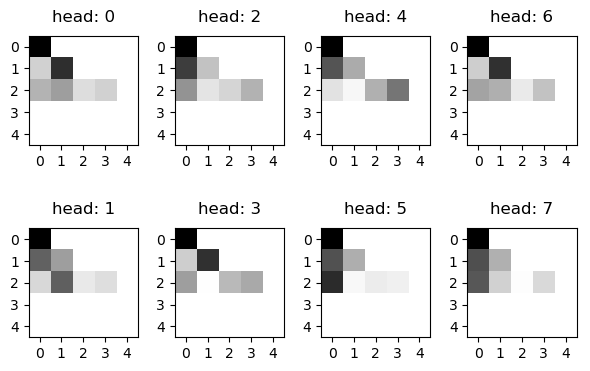

In [14]:
draw_attentions(n_head, attn)

## 3.3 Position-wise Feed-Forward Networks

$$FFN(x) = max(0, xW_1 + b_1)W_2 + b_2$$
$$\begin{aligned} W_1 &\in \Bbb{R}^{d_{model} \times d_f} \\ 
b_1 &\in \Bbb{R}^{d_f} \\
W_2 &\in \Bbb{R}^{d_f \times d_{model}} \\ 
b_2 &\in \Bbb{R}^{d_{model}} \\
\end{aligned}$$

same as $FFN = Linear(ReLU(Linear(x)) = Conv1d(ReLU(Conv1d(x)))$

In [15]:
class PositionWiseFFN(nn.Module):
    """Position-wise Feed-Forward Networks"""
    def __init__(self, d_model, d_f, drop_rate=0.1, use_conv=False):
        super(PositionWiseFFN, self).__init__()
        self.use_conv = use_conv
        self.layer_norm = nn.LayerNorm(d_model)
        
        if use_conv:
            self.fc = nn.Sequential(
                nn.Conv1d(d_model, d_f, kernel_size=1),
                nn.ReLU(),
                nn.Conv1d(d_f, d_model, kernel_size=1)
            )
        else:
            self.fc = nn.Sequential(
                nn.Linear(d_model, d_f),
                nn.ReLU(),
                nn.Linear(d_f, d_model)
            )
        self.drop_out = nn.Dropout(drop_rate)
    
    def forward(self, x):
        """
        Inputs:
        x: (B, T, d_model)
        -----------------------
        Ouputs:
        output: (B, T, d_model)
        """
        residual = x
        
        if self.use_conv:
            # (B, T, d_model) --> (B, d_model, T), reshape like (batch, channel, dim)
            x = x.transpose(1, 2)  
            # (B, d_model, T) --> (B, T, d_model)
            output = self.fc(x).transpose(1, 2)  
        else:
            output = self.fc(x)
            
        output = self.drop_out(output)
        output = self.layer_norm(residual + output)
        
        return output

In [16]:
d_f = d_model*4
PWFFN = PositionWiseFFN(d_model, d_f, use_conv=False)
PWFFN(o).size()

torch.Size([1, 5, 24])

In [17]:
PWFFN = PositionWiseFFN(d_model, d_f, use_conv=True)
PWFFN(o).size()

torch.Size([1, 5, 24])

## 3.5 Positional Encoding & Embeddings

$$\begin{aligned} PE_{(pos, 2i)} &= sin(pos/10000^{2i / d_{model}}) \\
PE_{(pos, 2i+1)} &= cos(pos/10000^{2i / d_{model}}) \\
\end{aligned}$$

In [18]:
class PositionalEncoding(nn.Module):
    """Positional Encoding"""
    def __init__(self, n_pos, d_model, pos_pad_idx=0):
        """
        n_pos = position length, max sequence length + 1
        """
        super(PositionalEncoding, self).__init__()
        self.n_pos = n_pos
        self.d_model = d_model
        self.pe_table = np.array(self.get_pe_table())
        self.pe_table[:, 0::2] = np.sin(self.pe_table[:, 0::2])
        self.pe_table[:, 1::2] = np.cos(self.pe_table[:, 1::2])
        self.pe_table[pos_pad_idx, :] = 0  # embed all pad to 0
            
        self.pe = nn.Embedding.from_pretrained(torch.FloatTensor(self.pe_table), freeze=True)
        
    def cal_angle(self, pos, hid_idx):
        return pos / (10000 ** ((2*(hid_idx // 2) / self.d_model)) )
    
    def get_pe_table(self):
        return [[self.cal_angle(pos, i) for i in range(self.d_model)] for pos in range(self.n_pos)]         
        
    def forward(self, inputs):
        return self.pe(inputs)

In [19]:
class Embedding(nn.Module):
    """Custom Embedding Layer"""
    def __init__(self, vocab_len, d_model, padding_idx=1):
        super(Embedding, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_len, d_model, padding_idx=padding_idx)
        
    def forward(self, x):
        # In the embedding layers, authors multiply those weights by `sqrt(d_model)`
        return self.embedding(x) * np.sqrt(self.d_model)


In [94]:
n_pos = 4
vocab_len = 10
# x, po_x: input sentences, postions of input sentences  (4, 3)
x = torch.LongTensor(np.array([[6, 5, 3, 1], 
                               [2, 3, 1, 1], 
                               [5, 3, 6, 1], 
                               [3, 6, 2, 1]]))
po_x = torch.LongTensor(np.array([[1, 2, 3, 0], 
                                  [1, 2, 0, 0], 
                                  [1, 2, 3, 0], 
                                  [1, 2, 3, 0]]))
pos_layer = PositionalEncoding(n_pos+1, d_model, pos_pad_idx=0)
embed_layer = Embedding(vocab_len, d_model, padding_idx=1)

In [95]:
inputs = embed_layer(x) + pos_layer(po_x)
inputs.size()

torch.Size([4, 4, 24])

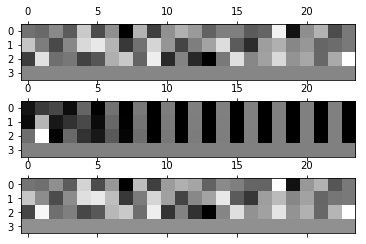

In [96]:
fig, axes = plt.subplots(3, 1)
axes[0].matshow(embed_layer(x)[0].detach().numpy(), cmap="binary")
axes[1].matshow(pos_layer(po_x)[0].detach().numpy(), cmap="binary")
axes[2].matshow(inputs[0].detach().numpy(), cmap="binary")

In [187]:
# target sentences
target_n_pos = 4  # equal to max_seq_len
t = torch.LongTensor(np.array([[2, 4, 3, 1], 
                               [2, 7, 9, 3], 
                               [2, 3, 1, 1], 
                               [2, 9, 3, 1]]))
po_t = torch.LongTensor(np.array([[1, 3, 2, 0], 
                                  [1, 3, 4, 2], 
                                  [1, 3, 0, 0], 
                                  [1, 3, 2, 0]]))
pos_layer = PositionalEncoding(target_n_pos+1, d_model)
embed_layer = Embedding(vocab_len, d_model, padding_idx=1)
target_inputs = embed_layer(t) + pos_layer(po_t)
target_inputs.size()

torch.Size([4, 4, 24])

In [188]:
pos_layer.pe

Embedding(5, 24)

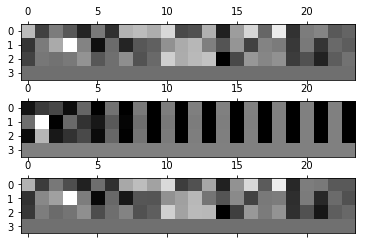

In [189]:
fig, axes = plt.subplots(3, 1)
axes[0].matshow(embed_layer(t)[0].detach().numpy(), cmap="binary")
axes[1].matshow(pos_layer(po_t)[0].detach().numpy(), cmap="binary")
axes[2].matshow(target_inputs[0].detach().numpy(), cmap="binary")

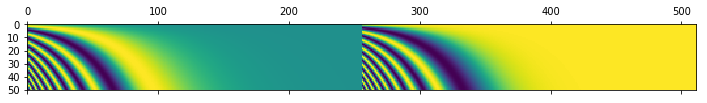

In [190]:
# visualize positional encoding
temp_d_model = 512
temp_n_pos = 50
temp_pos_layer = PositionalEncoding(temp_n_pos+1, temp_d_model)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.matshow(np.hstack([temp_pos_layer.pe_table[:, 0::2], temp_pos_layer.pe_table[:, 1::2]]))
plt.show()

In [191]:
# def get_padding_mask(q, k=None, pad_idx=1, mode='attn'):
#     """
#     mode: attn
#     > `pad_idx` is vocab pad_idx 
#     > mask out for pad in attention with queries & keys sequences
#     > return shape: (B, T_q, T_k)
#     mode: nonpad
#     > `pad_idx` is vocab pad_idx 
#     > mask out pad rows in attention
#     > return shape: (B, T_q, T_k)
#     mode: subseq
#     > mask out next tokens to preserve 'auto-regressive property'
#     > return shape: (B, T_q, T_q)
#     """
#     B, q_len = q.size()
#     if mode == 'attn':
#         assert k is not None, "must have key sequences"
#         padding_mask = k.eq(pad_idx)
#         padding_mask = padding_mask.unsqueeze(1).expand(B, q_len, -1)
#         return padding_mask
#     elif mode == 'nonpad':
#         # to mask out pad rows
#         assert k is None, "don't need key sequences"
#         return q.ne(pad_idx).type(torch.float).unsqueeze(-1)
#     elif mode =='subseq':
#         assert k is None, "don't need key sequences"
#         subseq_mask = torch.triu(torch.ones((q_len, q_len), device=q.device, dtype=torch.uint8), 
#                                  diagonal=1)
#         subseq_mask = subseq_mask.unsqueeze(0).expand(B, -1, -1)
#         return subseq_mask

In [192]:
def get_padding_mask(q, k=None, pad_idx=1, mode='attn'):
    """
    mode: attn
    > `pad_idx` is vocab pad_idx 
    > mask out for pad in attention with queries & keys sequences
    > return shape: (B, T_q, T_k)
    mode: subseq
    > mask out next tokens to preserve 'auto-regressive property'
    > return shape: (B, T_q, T_q)
    """
    B, q_len = q.size()
    B, k_len = k.size() if k is not None else (B, None)
    if mode == 'attn':
        assert k is not None, "must have key sequences"
        padding_mask = k.eq(pad_idx)
        padding_mask = padding_mask.unsqueeze(1).expand(B, q_len, -1)
        row_pad = q.eq(1).unsqueeze(-1).expand(B, q_len, k_len)
        padding_mask = (padding_mask + row_pad).ge(1)
        return padding_mask
    elif mode =='subseq':
        assert k is None, "don't need key sequences"
        subseq_mask = torch.triu(torch.ones((q_len, q_len), device=q.device, dtype=torch.uint8), 
                                 diagonal=1)
        subseq_mask = subseq_mask.unsqueeze(0).expand(B, -1, -1)
        return subseq_mask
    else:
        assert False, "error maksing"

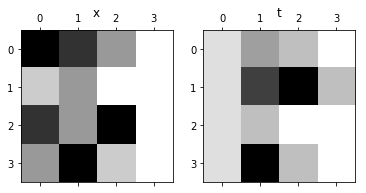

In [193]:
fig, axes = plt.subplots(1, 2)
axes[0].matshow(x.numpy(), cmap="binary")
axes[0].set_title("x")
axes[1].matshow(t.numpy(), cmap="binary")
axes[1].set_title("t")
plt.show()

In [194]:
get_padding_mask(t, x, pad_idx=1, mode="attn")

tensor([[[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 1, 1, 1]],

        [[0, 0, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 1, 1]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 1, 1, 1],
         [1, 1, 1, 1]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 1, 1, 1]]], dtype=torch.uint8)

In [195]:
get_padding_mask(t, t, pad_idx=1, mode="attn")

tensor([[[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 1, 1, 1]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[0, 0, 1, 1],
         [0, 0, 1, 1],
         [1, 1, 1, 1],
         [1, 1, 1, 1]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 1, 1, 1]]], dtype=torch.uint8)

In [196]:
get_padding_mask(x, x, pad_idx=1, mode="attn")

tensor([[[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 1, 1, 1]],

        [[0, 0, 1, 1],
         [0, 0, 1, 1],
         [1, 1, 1, 1],
         [1, 1, 1, 1]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 1, 1, 1]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 1, 1, 1]]], dtype=torch.uint8)

In [197]:
get_padding_mask(t, mode="subseq")

tensor([[[0, 1, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 0]],

        [[0, 1, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 0]],

        [[0, 1, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 0]],

        [[0, 1, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 0]]], dtype=torch.uint8)

In [198]:
attn_mask = get_padding_mask(q=t, k=t, pad_idx=1, mode='attn')
subseq_mask = get_padding_mask(q=t, mode='subseq')
self_attn_mask = (attn_mask + subseq_mask).gt(0)

In [199]:
self_attn_mask # decoder

tensor([[[0, 1, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 0, 1],
         [1, 1, 1, 1]],

        [[0, 1, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 0]],

        [[0, 1, 1, 1],
         [0, 0, 1, 1],
         [1, 1, 1, 1],
         [1, 1, 1, 1]],

        [[0, 1, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 0, 1],
         [1, 1, 1, 1]]], dtype=torch.uint8)

In [202]:
# decoder self attention
multiheadattention = MultiHeadAttention(n_head, d_model, d_k, d_v)
multiheadattention.eval()
o, attn = multiheadattention(q=target_inputs, k=target_inputs, v=target_inputs, mask=self_attn_mask)
o.size()

torch.Size([4, 4, 24])

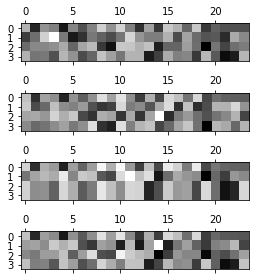

In [203]:
fig, axes = plt.subplots(4, 1)
for i in range(4):
    axes[i].matshow(o[i].detach().numpy(), cmap="binary")
plt.tight_layout()
plt.show()

## Layers

In [204]:
# Encode Layer
class Encode_Layer(nn.Module):
    """encode layer"""
    def __init__(self, n_head, d_model, d_k, d_v, d_f, drop_rate=0.1, use_conv=False):
        super(Encode_Layer, self).__init__()
        self.n_head = n_head
        self.selfattn = MultiHeadAttention(n_head, d_model, d_k, d_v, drop_rate=drop_rate)
        self.pwffn = PositionWiseFFN(d_model, d_f, drop_rate=drop_rate, use_conv=use_conv)
        
    def forward(self, enc_input, enc_mask=None):

        """
        Inputs:
        * enc_input: (B, T_e, d_model)
        * enc_mask: (B, T_e, T_e)
        * non_pad_mask: (B, T_e, 1)
        -------------------------------------
        Outputs:
        * enc_output: (B, T_e, d_model)
        * enc_attn: (n_head*B, T_e, T_e)
        """
        # Layer: Multi-Head Attention + Add & Norm
        # encode self-attention
        enc_output, enc_attn = self.selfattn(enc_input, enc_input, enc_input, mask=enc_mask)
        
        # Layer: PositionWiseFFN + Add & Norm
        pw_output = self.pwffn(enc_output)

        return enc_output, enc_attn

In [207]:
# Decode Layer
class Decode_Layer(nn.Module):
    """decode layer"""
    def __init__(self, n_head, d_model, d_k, d_v, d_f, drop_rate=0.1, use_conv=False):
        super(Decode_Layer, self).__init__()
        self.n_head = n_head
        self.selfattn_masked = MultiHeadAttention(n_head, d_model, d_k, d_v, drop_rate=drop_rate)
        self.dec_enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, drop_rate=drop_rate)
        self.pwffn = PositionWiseFFN(d_model, d_f, drop_rate=drop_rate, use_conv=use_conv)
    
    def forward(self, dec_input, enc_output, dec_self_mask=None, dec_enc_mask=None):
        """
        Inputs:
        * dec_input: (B, T_d, d_model)
        * enc_input: (B, T_e, d_model)
        * dec_self_mask: (B, T_d, T_d)
        * dec_enc_mask: (B, T_d, T_e)
        * non_pad_mask: (B, T_d, 1)
        -------------------------------------
        Outputs:
        * dec_output: (B, T_d, d_model)
        * dec_self_attn: (n_head*B, T_d, T_d)
        * dec_enc_attn: (n_head*B, T_d, T_e)
        """
        # Layer: Multi-Head Attention + Add & Norm
        # decode self-attention
        dec_self_output, dec_self_attn = \
            self.selfattn_masked(dec_input, dec_input, dec_input, mask=dec_self_mask)
        
        # Layer: Multi-Head Attention + Add & Norm
        # decode output(queries) + encode output(keys, values)
        dec_output, dec_enc_attn = \
            self.dec_enc_attn(dec_self_output, enc_output, enc_output, mask=dec_enc_mask)
        
        # Layer: PositionWiseFFN + Add & Norm
        dec_output = self.pwffn(dec_output)

        return dec_output, (dec_self_attn, dec_enc_attn)    

In [208]:
enc_layer = Encode_Layer(n_head, d_model, d_k, d_v, d_f)
dec_layer = Decode_Layer(n_head, d_model, d_k, d_v, d_f)

enc_mask = get_padding_mask(x, x, pad_idx=1, mode='attn')
enc_layer.eval()
enc_output, enc_attn = enc_layer.forward(inputs, enc_mask=enc_mask)


print(enc_mask.size())
print(enc_output.size(), enc_attn.size())

torch.Size([4, 4, 4])
torch.Size([4, 4, 24]) torch.Size([32, 4, 4])


In [209]:
dec_mask = (get_padding_mask(t, t, pad_idx=1, mode='attn') + \
    get_padding_mask(t, pad_idx=1, mode='subseq')).gt(0)
dec_enc_mask = get_padding_mask(t, x, pad_idx=1, mode='attn')
dec_layer.eval()
dec_output, (dec_self_attn, dec_enc_attn) = dec_layer.forward(target_inputs, 
                                                            enc_output, 
                                                            dec_self_mask=dec_mask, 
                                                            dec_enc_mask=dec_enc_mask)

# print(dec_mask.size(), dec_enc_mask.size(), non_pad_mask.size())
print(dec_mask.size(), dec_enc_mask.size())
print(enc_output.size(), dec_self_attn.size(), dec_enc_attn.size())

torch.Size([4, 4, 4]) torch.Size([4, 4, 4])
torch.Size([4, 4, 24]) torch.Size([32, 4, 4]) torch.Size([32, 4, 4])


In [210]:
x

tensor([[6, 5, 3, 1],
        [2, 3, 1, 1],
        [5, 3, 6, 1],
        [3, 6, 2, 1]])

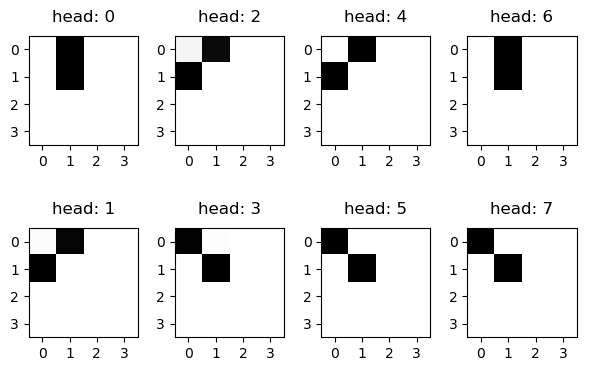

In [211]:
# there is only 2 sequence in 2nd sentence of x
enc_output.size(), enc_attn.size()
draw_attentions(n_head, torch.stack(torch.chunk(enc_attn, n_head))[:, 1, :, :])

In [212]:
t

tensor([[2, 4, 3, 1],
        [2, 7, 9, 3],
        [2, 3, 1, 1],
        [2, 9, 3, 1]])

In [217]:
dec_mask[1]

tensor([[0, 1, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 0]], dtype=torch.uint8)

torch.Size([4, 4, 24]) torch.Size([32, 4, 4]) torch.Size([32, 4, 4])
1st batch: decoder self attentions


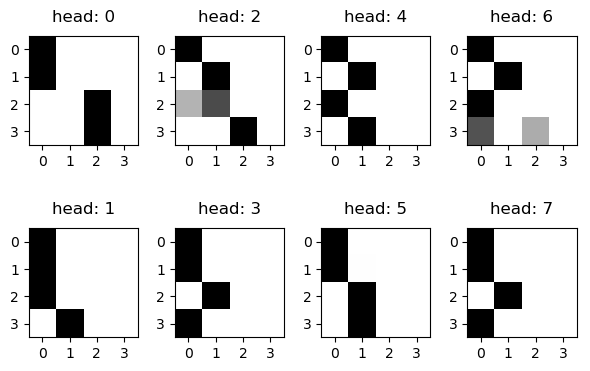

1st batch: decoder-encoder self attentions


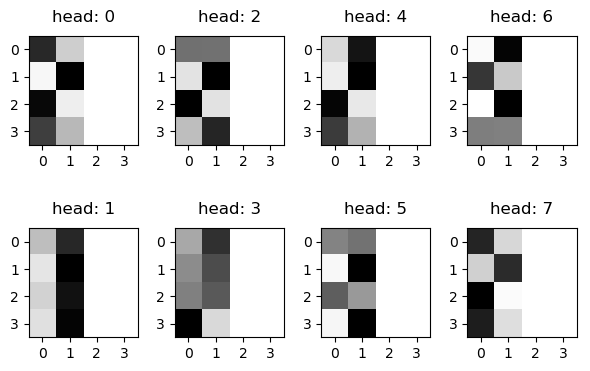

In [215]:
print(dec_output.size(), dec_self_attn.size(), dec_enc_attn.size())
print("2st batch: decoder self attentions")
draw_attentions(n_head, torch.stack(torch.chunk(dec_self_attn, n_head))[:, 1, :, :])
print("2st batch: decoder-encoder self attentions")
draw_attentions(n_head, torch.stack(torch.chunk(dec_enc_attn, n_head))[:, 1, :, :])

## Models: Encoder & Decoder - Transformer

In [234]:

# Encoder 
class Encoder(nn.Module):
    def __init__(self, vocab_len, max_seq_len, n_layer, n_head, d_model, d_k, d_v, d_f, 
                 drop_rate=0.1, use_conv=False, pad_idx=1, pos_pad_idx=0):
        super(Encoder, self).__init__()
        self.n_head = n_head
        self.pad_idx = pad_idx
        self.drop_out = nn.Dropout(drop_rate)
        self.embed_layer = Embedding(vocab_len, d_model, padding_idx=pad_idx)
#         n_pos = max_seq_len + sum([1 for x in (pad_idx, sos_idx, eos_idx) if x is not None])
        self.pos_layer = PositionalEncoding(max_seq_len+1, d_model, pos_pad_idx=pos_pad_idx)
        self.layers = nn.ModuleList([Encode_Layer(n_head, d_model, d_k, d_v, d_f, 
                                                  drop_rate=drop_rate, 
                                                  use_conv=use_conv) \
                                     for i in range(n_layer)])
        
    def forward(self, enc, enc_pos, return_attn=False):
        """
        Inputs:
        * enc: (B, T_e)
        * enc_pos: (B, T_e)
        -------------------------------------
        Outputs:
        * enc_output: (B, T_e, d_model)
        * self_attns: n_layer * (n_head, B, T_e, T_e)
        """
        self_attns = []  # n_layer * (n_head, B, T_e, T_e)
        # self attention padding mask: (B, T_e, T_e)
        attn_mask = get_padding_mask(q=enc, k=enc, pad_idx=self.pad_idx, mode='attn')
        
        # embedding + position encoding: (B, T_e) --> (B, T_e, d_model)
        enc_output = self.embed_layer(enc) + self.pos_layer(enc_pos)
        enc_output = self.drop_out(enc_output)
        
        # forward encode layer
        for enc_layer in self.layers:
            enc_output, enc_self_attn = enc_layer(enc_input=enc_output, 
                                                  enc_mask=attn_mask)
            self_attns.append(torch.stack(torch.chunk(enc_self_attn, self.n_head)))
        
        if return_attn:
            return enc_output, self_attns
        else:
            return enc_output

In [245]:
class Decoder(nn.Module):
    def __init__(self, vocab_len, max_seq_len, n_layer, n_head, d_model, d_k, d_v, d_f, 
                 drop_rate=0.1, use_conv=False, pad_idx=1, pos_pad_idx=0):
        super(Decoder, self).__init__()
        self.n_head = n_head
        self.pad_idx = pad_idx
        self.dropout = nn.Dropout(drop_rate)
        self.embed_layer = Embedding(vocab_len, d_model, padding_idx=pad_idx)
        # decoder position embedding have to add 3 since there are <s>, </s> token
#         n_pos = max_seq_len + sum([1 for x in (pad_idx, sos_idx, eos_idx) if x is not None])
        self.pos_layer = PositionalEncoding(max_seq_len+1, d_model, pos_pad_idx=pos_pad_idx)
        self.layers = nn.ModuleList([Decode_Layer(n_head, d_model, d_k, d_v, d_f, 
                                                  drop_rate=drop_rate, 
                                                  use_conv=use_conv) \
                                     for i in range(n_layer)])
        
    def forward(self, dec, dec_pos, enc, enc_output, return_attn=False):
        """
        Inputs:
        * dec: (B, T_d)
        * dec_pos: (B, T_d)
        * enc: (B, T_e)
        * enc_output: (B, T_d, d_model)
        -------------------------------------
        Outputs:
        * dec_output: (B, T_d, d_model)
        * self_attns: n_layer *(n_head, B, T_d, T_d)
        * dec_enc_attns: n_layer *(n_head, B, T_d, T_e)
        """
        self_attns = []  # n_layer * (n_head, B, T_d, T_d)
        dec_enc_attns = []  # n_layer * (n_head, B, T_d, T_e)
        
        
        # self attention padding mask: (B, T_d, T_d)
        attn_mask = get_padding_mask(q=dec, k=dec, pad_idx=self.pad_idx, mode='attn')
        subseq_mask = get_padding_mask(q=dec, mode='subseq')
        self_attn_mask = (attn_mask + subseq_mask).gt(0)
        # enc_dec attention padding mask: (B, T_d, T_e)
        dec_enc_attn_mask = get_padding_mask(q=dec, k=enc, pad_idx=self.pad_idx, mode='attn')
        
        # embedding + position encoding: (B, T_d) --> (B, T_d, d_model)
        dec_output = self.embed_layer(dec) + self.pos_layer(dec_pos)
        dec_output = self.dropout(dec_output)
        # forward decode layer
        for dec_layer in self.layers:
            dec_output, (dec_self_attn, dec_enc_attn) = \
                    dec_layer(dec_input=dec_output, 
                              enc_output=enc_output, 
                              dec_self_mask=self_attn_mask, 
                              dec_enc_mask=dec_enc_attn_mask)
            
            self_attns.append(torch.stack(torch.chunk(dec_self_attn, self.n_head)))
            dec_enc_attns.append(torch.stack(torch.chunk(dec_enc_attn, self.n_head)))
        
        if return_attn:
            return dec_output, (self_attns, dec_enc_attns)
        else:
            return dec_output
    

In [246]:
n_layer = 3
encoder = Encoder(vocab_len, 4, n_layer, n_head, d_model, d_k, d_v, d_f)
decoder = Decoder(vocab_len, 4, n_layer, n_head, d_model, d_k, d_v, d_f)

In [247]:
encoder.eval()
decoder.eval()
enc_output, enc_self_attns = encoder(x, po_x, return_attn=True)
dec_output, (dec_self_attns, dec_enc_attns) = decoder(t, po_t, x, enc_output, return_attn=True)

In [248]:
enc_output.size(), dec_output.size()

(torch.Size([4, 4, 24]), torch.Size([4, 4, 24]))

In [288]:
class Transformer(nn.Module):
    """Transformer Model"""
    def __init__(self, enc_vocab_len, enc_max_seq_len, dec_vocab_len, dec_max_seq_len, 
                 n_layer, n_head, d_model, d_k, d_v, d_f, 
                 pad_idx=1, pos_pad_idx=0, drop_rate=0.1, use_conv=False,
                 linear_weight_share=True, embed_weight_share=False):
        super(Transformer, self).__init__()
        self.pad_idx = pad_idx
        self.d_model = d_model
        
        self.encoder = Encoder(enc_vocab_len, enc_max_seq_len, n_layer, n_head, 
                               d_model, d_k, d_v, d_f, 
                               pad_idx=pad_idx, 
                               pos_pad_idx=pos_pad_idx,
                               drop_rate=drop_rate,
                               use_conv=use_conv)
        self.decoder = Decoder(dec_vocab_len, dec_max_seq_len, n_layer, n_head, 
                               d_model, d_k, d_v, d_f,
                               pad_idx=pad_idx, 
                               pos_pad_idx=pos_pad_idx,
                               drop_rate=drop_rate, 
                               use_conv=use_conv)
        self.projection = nn.Linear(d_model, dec_vocab_len, bias=False)
        if linear_weight_share:
            # share the same weight matrix between the decoder embedding layer 
            # and the pre-softmax linear transformation
            self.projection.weight = self.decoder.embed_layer.embedding.weight
        
        if embed_weight_share:
            # share the same weight matrix between the decoder embedding layer 
            # and the encoder embedding layer
            assert enc_vocab_len == dec_vocab_len, "vocab length must be same"
            self.encoder.embed_layer.embedding.weight = self.decoder.embed_layer.embedding.weight
            
    def forward(self, enc, enc_pos, dec, dec_pos, return_attn=False):
        """
        Inputs:
        * enc: (B, T_e)
        * enc_pos: (B, T_e)
        * dec: (B, T_d)
        * dec_pos: (B, T_d)
        -------------------------------------
        Outputs:
        * dec_output: (B, T_d, V)
        * attns_dict:
            * enc_self_attns: n_layers * (n_head, B, T_e, T_e)
            * dec_self_attns: n_layers * (n_head, B, T_d, T_d)
            * dec_enc_attns: n_layers * (n_haed, B, T_d, T_e)
        """
        
        # given previous dec inputs predict next dec
        dec = dec[:, :-1]
        dec_pos = dec_pos[:, :-1]
        
        if return_attn:
            enc_output, enc_self_attns = self.encoder(enc, enc_pos, return_attn)
            dec_output, (dec_self_attns, dec_enc_attns) = self.decoder(dec, dec_pos, enc, enc_output, return_attn)
            dec_output = self.projection(dec_output)
            attns_dict = {'enc_self_attns': enc_self_attns, 
                         'dec_self_attns': dec_self_attns,
                         'dec_enc_attns': dec_enc_attns}
            return dec_output, attns_dict
        else:
            enc_output = self.encoder(enc, enc_pos, return_attn)
            dec_output = self.decoder(dec, dec_pos, enc, enc_output, return_attn)
            dec_output = self.projection(dec_output)
            return dec_output

In [289]:
model = Transformer(vocab_len, 4, vocab_len, 4, n_layer, n_head, d_model, d_k, d_v, d_f, 
                    pad_idx=1, pos_pad_idx=0, drop_rate=0.1, use_conv=False, 
                    linear_weight_share=False, embed_weight_share=False)

In [297]:
model.eval()
output = model(x, po_x, t, po_t, return_attn=False)
real_target = t[:, 1:].contiguous()

In [298]:
real_target.view(-1)

tensor([4, 3, 1, 7, 9, 3, 3, 1, 1, 9, 3, 1])

In [292]:
torch.softmax(output.view(-1, 10), 1).argmax(-1)

tensor([4, 9, 9, 7, 3, 7, 4, 9, 3, 3, 9, 9])

---

## Label Smoothing

* Ref: https://arxiv.org/pdf/1512.00567.pdf

For each training example x, our model computes the probability of each label $k \in \{1 \cdots K\}: p(k \vert x) =\text{softmax}(x) = \dfrac{\exp(z_k)}{\sum_i^K \exp(z_i)}$
. Here, $z_i$ are the logits or unnormalized logprobabilities. Consider the ground-truth distribution over labels $q(k\vert x)$ for this training example, normalized so that $\sum_k q(k\vert x) = 1$

omit $x$


cross-entropy: $l = - \sum_{k=1}^{K} \log(p(k))q(k)$

The gradient has a rather simple form: $\dfrac{\partial l}{\partial z_k} = p(k) - q(k)$ which is bounded
between −1 and 1.

Consider the case of a single ground-truth label $y$, so that $q(y) = 1$ and $q(k) = 0$ for all $k \neq y$.  In this case, minimizing the cross entropy is equivalent to maximizing the log-likelihood of the correct label. For a particular example $x$ with label $y$, the log-likelihood is maximized for $q(k) = \delta_{k,y}$, where $\delta_{k,y}$ is Dirac delta, which equals 1 for $k = y$ and $0$ otherwise. This maximum is not achievable for finite $z_k$ but is approached if $zy \gg zk$ for all $k \neq y$ – that is, if the logit corresponding to the ground-truth label is much great than all other logits. 

This, however, can cause two problems. First, it may result in over-fitting: if the model learns to assign full probability to the groundtruth label for each training example, it is not guaranteed to
generalize. Second, it encourages the differences between the largest logit and all others to become large, and this, combined with the bounded gradient $\dfrac{\partial l}{\partial z_k} = p(k) - q(k)$, reduces the ability of the model to adapt. Intuitively, this happens because the model becomes too confident about its predictions.

Only using cross-entropy loss cause two problems. First, it may result in over-fitting: if the model learns to assign full probability to the groundtruth label for each training example, it is not guaranteed to generalize. Second, it encourages the differences between the largest logit and all others to become large, and this, combined with the bounded gradient $\frac{\partial l}{\partial z_{k}}$, reduces the ability of the model to adapt. Intuitively, this happens because the model becomes too confident about its predictions

### proposed method: label-smoothing regularization

* $u(k)$: a distribution over labels, independent of the training example $x$
* $\epsilon$: a smoothing parameter

For a training example with ground-truth label $y$, replace the label distribution $q(k) = \delta_{k, y}$ to

$$q'(k \vert x) = (1-\epsilon)\delta_{k, y}+\epsilon u(k)$$

This can be seen as the distribution of the label $k$ obtained as follows: first, set it to the groundtruth label $k = y$; then, with probability $\epsilon$, replace $k$ with a sample drawn from the distribution $u(k)$. We propose to use the prior distribution over labels as $u(k)$. In our experiments, we used the uniform distribution $u(k) = 1/K$, so that

$$q'(k \vert x) = (1-\epsilon)\delta_{k, y}+ \dfrac{\epsilon}{K}$$

Another interpretation: $q'$ is changed true probability.

$$\begin{aligned} H(q', p) &= -\sum_{k=1}^K q'(k) \log p(k)  \\
&= -\sum_{k=1}^K \big( ((1-\epsilon)q(x) + \epsilon u(x)) \log p(k) \big) \\
&= -\sum_{k=1}^K (1-\epsilon)q(x) \log p(k) -\sum_{k=1}^K \epsilon u(x) \log p(k) \\
&= (1-\epsilon) H(q, p) + \epsilon H(u, p) \end{aligned}$$

this can be seen as $H(q', p) = H(q, p) + \dfrac{\epsilon}{(1-\epsilon) } \big( D_{KL}(u \vert\vert p) + H(u) \big) $ and $H(u)$ is fixed. When $u$ is the uniform distribution, $H(u, p)$ is a measure of how dissimilar the predicted distribution $p$ is to uniform, which could also be measured (but not equivalently) by negative entropy $−H(p)$;

* $H(u, p) = D_{KL}(u \vert\vert p) + H(u)$


In [303]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LabelSmoothing(nn.Module):
    """Label Smoothing"""
    def __init__(self, trg_vocab_size, pad_idx, eps=0.0):
        """
        - eps: smoothing parameters, set it 0.0 to use crossentropy
        
        -------------------------------------------------
        ref: https://arxiv.org/pdf/1512.00567.pdf
        ref: http://nlp.seas.harvard.edu/2018/04/03/attention.html
        #7
        - k : predict class
        - y : target class 
        In Cross Entropy H(q, p) = -\sum q(k|x) log p(k|x)
        replace ground truth distribution (q(k|x) = \delta_{k, y}) to
        q'(k|x) = (1 - eps) q(k|x) + eps * u(k)
        where: q(k|x) = 1 if k == y else 0, u(k) = unifrom distribution to labels (ex. 1/K)
        
        Equal to H(q', p) = H(q, p) + eps/(1-eps) * (D_KL(u || p) + H(u))
        """
        super(LabelSmoothing, self).__init__()
        if eps == 0.0:
            self.criterion = nn.CrossEntropyLoss(ignore_index=pad_idx, reduction='sum')
        else:
            self.criterion = nn.KLDivLoss(reduction='sum')
        self.pad_idx = pad_idx
        self.eps = eps
        self.trg_vocab_size = trg_vocab_size
        
    def forward(self, x, t):
        """
        Inputs:
        x: (B, T_d, V_target), predict scores
        t: (B, T_d)
        """
        assert x.size(2) == self.trg_vocab_size, \
            'vocab size is not equal x: {}, vocab: {}'.format(x.size(2), self.trg_vocab_size)
        assert t.dim() == 2, 't must be size of (B, T_q)'
        
        target = t.contiguous().view(-1)
        pred = x.view(-1, x.size(-1))
        
        # option to not use label smoothing
        if self.eps == 0.0:
            return self.criterion(pred, target)
        # onehot encoding
        delta_ky = torch.zeros_like(pred).scatter(dim=1, index=target.unsqueeze(1), source=1)
        # smoothing
        smoothed_dist = (1 - self.eps) * delta_ky + (1 - delta_ky) * self.eps / (self.trg_vocab_size - 1)
        smoothed_dist[:, self.pad_idx] = 0.0
        pad_mask = torch.nonzero(target == self.pad_idx).squeeze()
        smoothed_dist = smoothed_dist.index_fill(0, pad_mask, 0.0)
        # probability and cal loss
        log_prob = F.log_softmax(pred, dim=1)
        loss = self.criterion(log_prob, smoothed_dist)
        
        self.smoothed_dist = smoothed_dist
        return loss
        
#         # onehot encoding
#         delta_ky = torch.zeros_like(pred).scatter(dim=1, index=target.unsqueeze(1), source=1)
#         # smoothing
#         smoothed_dist = (1 - self.eps) * delta_ky + (1 - delta_ky) * self.eps / (self.trg_vocab_size - 1)
#         # probability and cal loss
#         log_prob = F.log_softmax(pred, dim=1)
#         non_pad_mask = target.ne(self.pad_idx)
#         loss = -(smoothed_dist * log_prob).sum(dim=1)
#         loss = loss.masked_select(non_pad_mask).sum()
        
#         # 이전코드
#         non_pad_mask = get_padding_mask(q=target, pad_idx=1, mode='nonpad')
#         # label smoothing
#         delta_ky = torch.zeros_like(x)
#         delta_ky = delta_ky.scatter(dim=2, index=target.unsqueeze(-1), source=1)
#         # -2: exclude <s>, </s> token
#         # smoothed_dist: B, T_d, vocab_size
#         smoothed_dist = (1 - self.eps) * delta_ky + self.eps / (self.trg_vocab_size - 2)
#         smoothed_dist *= non_pad_mask
#         log_prob = F.log_softmax(x, dim=2)
#         loss = (-(smoothed_dist * log_prob)).sum()
    
        

In [304]:
lbs = LabelSmoothing(trg_vocab_size=vocab_len, pad_idx=1, eps=0.1)

In [306]:
lbs(output, t[:, 1:])

tensor(11.7059, grad_fn=<KlDivBackward>)

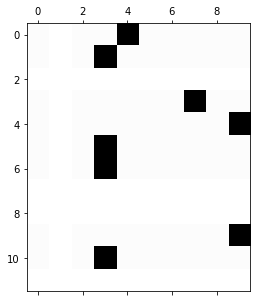

In [307]:
plt.matshow(lbs.smoothed_dist, cmap="binary")

In [308]:
lbs.smoothed_dist

tensor([[0.0111, 0.0000, 0.0111, 0.0111, 0.9000, 0.0111, 0.0111, 0.0111, 0.0111,
         0.0111],
        [0.0111, 0.0000, 0.0111, 0.9000, 0.0111, 0.0111, 0.0111, 0.0111, 0.0111,
         0.0111],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0111, 0.0000, 0.0111, 0.0111, 0.0111, 0.0111, 0.0111, 0.9000, 0.0111,
         0.0111],
        [0.0111, 0.0000, 0.0111, 0.0111, 0.0111, 0.0111, 0.0111, 0.0111, 0.0111,
         0.9000],
        [0.0111, 0.0000, 0.0111, 0.9000, 0.0111, 0.0111, 0.0111, 0.0111, 0.0111,
         0.0111],
        [0.0111, 0.0000, 0.0111, 0.9000, 0.0111, 0.0111, 0.0111, 0.0111, 0.0111,
         0.0111],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0111, 0.0000, 0.0111, 0.0111, 0.0111, 0.0111, 0.0111, 0.0111, 0.0111,
         0.9000],
        [0

---

## Optimizer

In [309]:
class WarmUpOptim(object):
    """Varied the Learning Rate"""
    def __init__(self, warmup_steps, d_model, optimizer):
        """
        ref: http://nlp.seas.harvard.edu/2018/04/03/attention.html
        """
        self._optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.d_model = d_model
        self._step = 0
        self._lrate = 0
        
    def step(self):
        """Update parameters and rate"""
        self._step += 1
        lrate = self.cal_rate()
        for p in self._optimizer.param_groups:
            p["lr"] = lrate
        self._lrate = lrate
        self._optimizer.step()
        
    def zero_grad(self):
        """zero_grad for optimizer"""
        return self._optimizer.zero_grad()
    
    def cal_rate(self, step=None):
        """lrate = d_model**(-0.5) * min(step**(-0.5), step*warmup_steps**(-1.5))"""
        if step is None:
            step = self._step
            
        lrate = self.d_model**(-0.5) * min(step**(-0.5), step*self.warmup_steps**(-1.5))
        return lrate

In [310]:
warmup_steps = 4000
optimizer = WarmUpOptim(warmup_steps=warmup_steps, d_model=d_model, 
                        optimizer=optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=10e-9))

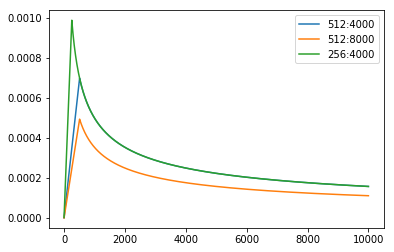

In [311]:
# Three settings of the lrate hyperparameters.
# ref: http://nlp.seas.harvard.edu/2018/04/03/attention.html
opts = [WarmUpOptim(512, 4000, None), 
        WarmUpOptim(512, 8000, None),
        WarmUpOptim(256, 4000, None)]
plt.plot(np.arange(1, 10000), [[opt.cal_rate(i) for opt in opts] for i in range(1, 10000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
plt.show()

In [312]:
import torch

In [313]:
def get_pos(x, pad_idx=1, sos_idx=None, eos_idx=None, pos_pad_idx=0):
    """
    return postion of tensor function
    pos idx(in the vocabulary):
     - pad = 0
     - sos = 1 if exist 
     - eos = 2 if exist (if only eos exist, eos will be 1)
    start idx will be 1 or 2 if one exist or 3 if all exist
    """
    exists = lambda x: x is not None
    
    def process_sos(pos, idx):
        pos[:, 0] = idx
        return pos
    
    def process_eos(pos, x, eos_idx, pos_eos_idx):
        eos_mask = (x == eos_idx)
        pos = (pos+1).masked_fill(eos_mask, pos_eos_idx) 
        return pos
        
    B, T = x.size()
    pos = torch.arange(1, T+1, device=x.device).expand(B, -1)
    if not exists(sos_idx) and exists(eos_idx):
        pos_eos_idx = 1
        pos = process_eos(pos, x, eos_idx, pos_eos_idx)
    elif exists(sos_idx) and exists(eos_idx):
        pos_eos_idx = 2
        pos = process_eos(pos, x, eos_idx, pos_eos_idx)
        pos = process_sos(pos, 1)
        
    padding_mask = (x == pad_idx)
    pos = pos.masked_fill(padding_mask, pos_pad_idx)
    return pos

In [314]:
y = torch.LongTensor([[2, 7, 6, 8, 5, 3, 1],
                      [2, 9, 6, 6, 3, 1, 1],
                      [2, 4, 3, 1, 1, 1, 1]])

In [315]:
get_pos(y, pad_idx=1)

tensor([[1, 2, 3, 4, 5, 6, 0],
        [1, 2, 3, 4, 5, 0, 0],
        [1, 2, 3, 0, 0, 0, 0]])

In [316]:
get_pos(y, pad_idx=1, sos_idx=2)

tensor([[1, 2, 3, 4, 5, 6, 0],
        [1, 2, 3, 4, 5, 0, 0],
        [1, 2, 3, 0, 0, 0, 0]])

In [317]:
get_pos(y, pad_idx=1, eos_idx=3)

tensor([[2, 3, 4, 5, 6, 1, 0],
        [2, 3, 4, 5, 1, 0, 0],
        [2, 3, 1, 0, 0, 0, 0]])

In [318]:
get_pos(y,  pad_idx=1, sos_idx=2, eos_idx=3)

tensor([[1, 3, 4, 5, 6, 2, 0],
        [1, 3, 4, 5, 2, 0, 0],
        [1, 3, 2, 0, 0, 0, 0]])

In [319]:
x

tensor([[6, 5, 3, 1],
        [2, 3, 1, 1],
        [5, 3, 6, 1],
        [3, 6, 2, 1]])

In [320]:
t

tensor([[2, 4, 3, 1],
        [2, 7, 9, 3],
        [2, 3, 1, 1],
        [2, 9, 3, 1]])

In [321]:
# give tokens
t[:, :-1]

tensor([[2, 4, 3],
        [2, 7, 9],
        [2, 3, 1],
        [2, 9, 3]])

In [322]:
# gold target 이거때문에 자꾸 2 내 밷는구나 ;;
t[:, 1:]

tensor([[4, 3, 1],
        [7, 9, 3],
        [3, 1, 1],
        [9, 3, 1]])

In [323]:
x_pos = get_pos(x, pad_idx=1)
t_pos = get_pos(t, pad_idx=1, sos_idx=2, eos_idx=3)

In [324]:
print(x_pos)
print(t_pos)

tensor([[1, 2, 3, 0],
        [1, 2, 0, 0],
        [1, 2, 3, 0],
        [1, 2, 3, 0]])
tensor([[1, 3, 2, 0],
        [1, 3, 4, 2],
        [1, 2, 0, 0],
        [1, 3, 2, 0]])


In [325]:
model = Transformer(vocab_len, 4, vocab_len, 4, n_layer, n_head, d_model, d_k, d_v, d_f, 
                    pad_idx=1, pos_pad_idx=0, drop_rate=0.1, use_conv=False, 
                    linear_weight_share=False, embed_weight_share=False)

In [326]:
lbs = LabelSmoothing(trg_vocab_size=vocab_len, pad_idx=1, eps=0.1)

In [327]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [328]:
warmup_steps = 4000
optimizer = WarmUpOptim(warmup_steps=warmup_steps, d_model=d_model, 
                        optimizer=optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=10e-9))

In [329]:
for step in range(1000):
    optimizer.zero_grad()
    output = model(x, x_pos, t, t_pos)
    real_target = t[:, 1:].contiguous()
    loss = loss_function(output.view(-1, output.size(-1)), real_target.view(-1))
#     loss = lbs(output, t)
    loss.backward()
    optimizer.step()
    n_words = t.ne(1).sum()
    if step % 100 == 0:
        print(step, loss/n_words)

0 tensor(0.1998, grad_fn=<DivBackward0>)
100 tensor(0.1466, grad_fn=<DivBackward0>)
200 tensor(0.0909, grad_fn=<DivBackward0>)
300 tensor(0.0519, grad_fn=<DivBackward0>)
400 tensor(0.0260, grad_fn=<DivBackward0>)
500 tensor(0.0307, grad_fn=<DivBackward0>)
600 tensor(0.0219, grad_fn=<DivBackward0>)
700 tensor(0.0141, grad_fn=<DivBackward0>)
800 tensor(0.0052, grad_fn=<DivBackward0>)
900 tensor(0.0015, grad_fn=<DivBackward0>)


In [330]:
enc = torch.LongTensor([[2, 3, 1, 1]])
enc_pos = get_pos(enc)

In [331]:
enc_output, enc_self_attn = model.encoder(enc, enc_pos, return_attn=True)

In [332]:
dec = torch.LongTensor([[2]])
dec_pos = get_pos(dec, pad_idx=1, sos_idx=2, eos_idx=3)

attns = []
for i in range(7):
    dec_output, (dec_self_attn, dec_enc_attn) = model.decoder(dec, dec_pos, enc, enc_output, return_attn=True)
    score = model.projection(dec_output)
    pred = score[:, -1, :].argmax(-1)
    print(pred)
    attns.append((dec_self_attn, dec_enc_attn))
    dec = torch.cat((dec, pred.unsqueeze(0)), dim=1)
    dec_pos = get_pos(dec, pad_idx=1, sos_idx=2, eos_idx=3)
    

tensor([7])
tensor([9])
tensor([3])
tensor([1])
tensor([1])
tensor([1])
tensor([1])


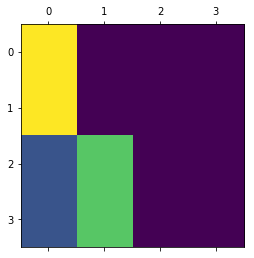

In [269]:
plt.matshow(enc_self_attn[0][0].squeeze().detach().numpy())